In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import optuna
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
optuna.logging.set_verbosity(optuna.logging.INFO)

In [2]:
dft = pd.read_csv(r"C:\Users\basde\Documents\GitHub\Code-and-examples\Projects\Binary Classification with a Bank Dataset\train.csv")
dfo = pd.read_csv(r"C:\Users\basde\Documents\GitHub\Code-and-examples\Projects\Binary Classification with a Bank Dataset\bank-full.csv", delimiter=';')

dfo['y'] = dfo['y'].map({'no' : 0, 'yes': 1})
df = pd.concat([dft, dfo])
y = df['y']
df = df.drop('y', axis=1)
df = df.drop(['id'], axis=1)
df['feature'] = df['duration'] * df['campaign'] * df['pdays']

In [16]:
test = pd.read_csv(r"C:\Users\basde\Documents\GitHub\Code-and-examples\Projects\Binary Classification with a Bank Dataset/test.csv")
testf = test.drop(['id'], axis=1)
testf['feature'] = testf['duration'] * testf['campaign'] * testf['pdays']

In [17]:
for col in categorical_features:
    test[col] = test[col].astype('category')

In [14]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 17 columns):
 #   Column     Non-Null Count   Dtype   
---  ------     --------------   -----   
 0   age        250000 non-null  int64   
 1   job        250000 non-null  category
 2   marital    250000 non-null  category
 3   education  250000 non-null  category
 4   default    250000 non-null  category
 5   balance    250000 non-null  int64   
 6   housing    250000 non-null  category
 7   loan       250000 non-null  category
 8   contact    250000 non-null  category
 9   day        250000 non-null  int64   
 10  month      250000 non-null  category
 11  duration   250000 non-null  int64   
 12  campaign   250000 non-null  int64   
 13  pdays      250000 non-null  int64   
 14  previous   250000 non-null  int64   
 15  poutcome   250000 non-null  category
 16  feature    250000 non-null  int64   
dtypes: category(9), int64(8)
memory usage: 17.4 MB


In [23]:
for col in categorical_features:
    # Get the categories from the training data for the current column.
    train_categories = df[col].cat.categories
    
    # Apply the same categorical type and categories to the test data.
    # This enforces consistency. Any value in the test column that is not
    # in 'train_categories' will become a NaN (Not a Number).
    testf[col] = pd.Categorical(testf[col], categories=train_categories, ordered=df[col].cat.ordered)
    
    # 3. Check for and fill any NaNs that were introduced.
    # A common strategy is to fill them with the mode (most frequent value)
    # from the training set for that column.
    if testf[col].isnull().sum() > 0:
        print(f"Unseen categories found in '{col}'. Filling with training set mode.")
        mode_value = df[col].mode()[0]
        testf[col] = testf[col].fillna(mode_value)

print("\nCategorical features have been aligned.")
print("You can now safely fit your model and predict on the test set.")

# As a final check, you can view the info of the test dataframe again.
# The dtypes and non-null counts should now be fully consistent.
print("\nTest DataFrame Info after alignment:")
testf.info()


Categorical features have been aligned.
You can now safely fit your model and predict on the test set.

Test DataFrame Info after alignment:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 17 columns):
 #   Column     Non-Null Count   Dtype   
---  ------     --------------   -----   
 0   age        250000 non-null  int64   
 1   job        250000 non-null  category
 2   marital    250000 non-null  category
 3   education  250000 non-null  category
 4   default    250000 non-null  category
 5   balance    250000 non-null  int64   
 6   housing    250000 non-null  category
 7   loan       250000 non-null  category
 8   contact    250000 non-null  category
 9   day        250000 non-null  int64   
 10  month      250000 non-null  category
 11  duration   250000 non-null  int64   
 12  campaign   250000 non-null  int64   
 13  pdays      250000 non-null  int64   
 14  previous   250000 non-null  int64   
 15  poutcome   250000 non-null  

In [15]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 795211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count   Dtype   
---  ------     --------------   -----   
 0   age        795211 non-null  int64   
 1   job        795211 non-null  category
 2   marital    795211 non-null  category
 3   education  795211 non-null  category
 4   default    795211 non-null  category
 5   balance    795211 non-null  int64   
 6   housing    795211 non-null  category
 7   loan       795211 non-null  category
 8   contact    795211 non-null  category
 9   day        795211 non-null  int64   
 10  month      795211 non-null  category
 11  duration   795211 non-null  int64   
 12  campaign   795211 non-null  int64   
 13  pdays      795211 non-null  int64   
 14  previous   795211 non-null  int64   
 15  poutcome   795211 non-null  category
 16  feature    795211 non-null  int64   
dtypes: category(9), int64(8)
memory usage: 61.4 MB


In [3]:

# Identify categorical features and set their type to 'category'
# This allows LightGBM to handle them natively and efficiently
categorical_features = df.select_dtypes(include=['object']).columns
for col in categorical_features:
    df[col] = df[col].astype('category')

# Define features (X) and target (y)


X = df


X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 795211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count   Dtype   
---  ------     --------------   -----   
 0   age        795211 non-null  int64   
 1   job        795211 non-null  category
 2   marital    795211 non-null  category
 3   education  795211 non-null  category
 4   default    795211 non-null  category
 5   balance    795211 non-null  int64   
 6   housing    795211 non-null  category
 7   loan       795211 non-null  category
 8   contact    795211 non-null  category
 9   day        795211 non-null  int64   
 10  month      795211 non-null  category
 11  duration   795211 non-null  int64   
 12  campaign   795211 non-null  int64   
 13  pdays      795211 non-null  int64   
 14  previous   795211 non-null  int64   
 15  poutcome   795211 non-null  category
 16  feature    795211 non-null  int64   
dtypes: category(9), int64(8)
memory usage: 61.4 MB


In [4]:
## 2. Optuna Objective Function with Cross-Validation
# ----------------------------------------------------

def objective(trial):
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.2, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0, step=0.05),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0, step=0.05),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
    }
    
    dtrain = lgb.Dataset(X, label=y, categorical_feature=list(categorical_features), free_raw_data=False)
    
    cv_results = lgb.cv(
        params=params,
        train_set=dtrain,
        num_boost_round=2000,
        nfold=5,
        stratified=True,
        seed=42,
        callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=False)]
    )
    

    cv_score = cv_results['valid auc-mean'][-1]

    cv_stdv = cv_results['valid auc-stdv'][-1]
    trial.set_user_attr('cv_stdv', cv_stdv)
    
    trial.set_user_attr('n_estimators', len(cv_results['valid auc-mean']))
    
    return cv_score





In [5]:
## 3. Run Tuning Study and Display Results
# -----------------------------------------
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=40)

results_df = study.trials_dataframe()

results_df = results_df[results_df['state'] == 'COMPLETE']

if not results_df.empty:
    results_df = results_df.rename(columns={
        'value': 'cv_score',
        'user_attrs_n_estimators': 'n_estimators',
        'user_attrs_cv_stdv': 'cv_std_dev'
    })
    results_df['params_learning_rate'] = results_df['params_learning_rate'].round(4)
    results_df['cv_score'] = results_df['cv_score'].round(5)
    results_df['cv_std_dev'] = results_df['cv_std_dev'].round(5)
    
    # Define columns to display (train_score and generalization_ratio are removed)
    param_cols = [col for col in results_df.columns if col.startswith('params_')]
    display_cols = ['cv_score', 'cv_std_dev', 'n_estimators'] + param_cols
    
    print("\n--- Hyperparameter Tuning Results Summary ---")
    print(results_df[display_cols].sort_values(by='cv_score', ascending=False).head(10))

[I 2025-08-04 23:46:31,190] A new study created in memory with name: no-name-652b3fc3-45a3-4dc8-a6f9-98fe9f0849a7
[I 2025-08-04 23:56:21,790] Trial 0 finished with value: 0.9613220576624446 and parameters: {'learning_rate': 0.01651077690021882, 'num_leaves': 122, 'max_depth': 3, 'min_child_samples': 21, 'subsample': 0.9, 'colsample_bytree': 0.95, 'reg_alpha': 0.023914610434615735, 'reg_lambda': 0.0002233906434169338}. Best is trial 0 with value: 0.9613220576624446.
[I 2025-08-05 00:11:11,440] Trial 1 finished with value: 0.9652564261505481 and parameters: {'learning_rate': 0.018255050019533457, 'num_leaves': 105, 'max_depth': 5, 'min_child_samples': 14, 'subsample': 0.95, 'colsample_bytree': 0.6, 'reg_alpha': 0.16679526030823139, 'reg_lambda': 2.2611070339122104}. Best is trial 1 with value: 0.9652564261505481.
[I 2025-08-05 00:22:20,142] Trial 2 finished with value: 0.9635870030710757 and parameters: {'learning_rate': 0.016480811636475454, 'num_leaves': 42, 'max_depth': 4, 'min_child_


--- Hyperparameter Tuning Results Summary ---
    cv_score  cv_std_dev  n_estimators  params_colsample_bytree  \
4    0.96773     0.00048          1998                     0.60   
33   0.96769     0.00047          1850                     0.65   
31   0.96767     0.00045          1996                     0.65   
32   0.96766     0.00045          1962                     0.65   
28   0.96760     0.00049          2000                     0.65   
27   0.96759     0.00047          2000                     0.65   
19   0.96757     0.00045          2000                     0.60   
21   0.96756     0.00049          2000                     0.60   
6    0.96750     0.00047          1112                     0.60   
34   0.96750     0.00047          2000                     0.75   

    params_learning_rate  params_max_depth  params_min_child_samples  \
4                 0.0129                12                        37   
33                0.0192                12                        64   

In [8]:
# This 'if' check ensures this block only runs if the study was successful
if not results_df.empty:


    ## 4. Review Best Trial and Train Final Model
    # ---------------------------------------------
    print("\n--- Best Trial Details ---")
    best_trial = study.best_trial
    print(f"Best CV Score: {best_trial.value:.5f}")
    print(f"Best CV Standard Deviation: {best_trial.user_attrs['cv_stdv']:.5f}")
    
    print("Best Parameters:")
    # Use .copy() to prevent the RuntimeError
    for key, value in best_trial.params.copy().items():
        print(f"  {key}: {value}")
        
    # This should be OUTSIDE the for loop, so it only prints once
    print(f"  n_estimators: {best_trial.user_attrs['n_estimators']}")

    # This entire block for training the model should also be OUTSIDE the for loop
    print("\nTraining final model with best parameters...")
    best_params = best_trial.params
    best_params['n_estimators'] = best_trial.user_attrs['n_estimators']

    final_model = lgb.LGBMClassifier(**best_params)
    final_model.fit(X, y, categorical_feature=list(categorical_features))
    print("Final model trained and ready. ✅")
else:
    # This runs if no trials were completed successfully
    print("\nStudy finished, but no trials were completed successfully.")


--- Best Trial Details ---
Best CV Score: 0.96773
Best CV Standard Deviation: 0.00048
Best Parameters:
  learning_rate: 0.012943789331495266
  num_leaves: 290
  max_depth: 12
  min_child_samples: 37
  subsample: 1.0
  colsample_bytree: 0.6
  reg_alpha: 0.0008789983887914183
  reg_lambda: 1.7115784313850568e-05
  n_estimators: 1998

Training final model with best parameters...
Final model trained and ready. ✅



--- Generating Learning Curve for the Best Model ---
Plotting learning curve...


<Figure size 1000x600 with 0 Axes>

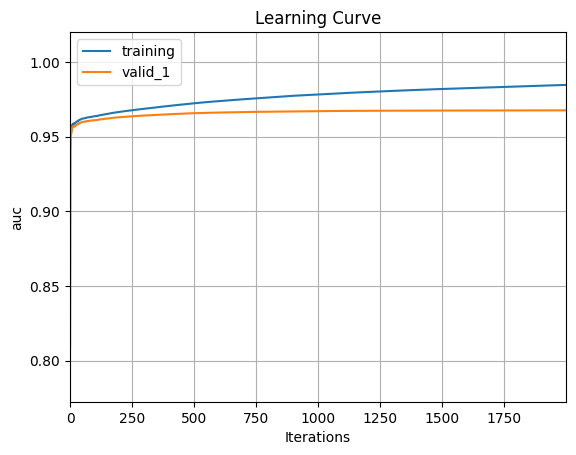

In [7]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# This assumes you have already run the tuning script and have:
# - A trained 'final_model'
# - The 'X' and 'y' dataframes
# - The list of 'categorical_features'

print("\n--- Generating Learning Curve for the Best Model ---")

# We need a validation set to plot the curve
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Re-fit the final model on the new training split and track performance
final_model.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    eval_metric='auc',
    callbacks=[lgb.early_stopping(100, verbose=False)]
)

# Plot the learning curve
print("Plotting learning curve...")
plt.figure(figsize=(10, 6))
lgb.plot_metric(final_model, metric='auc', title='Learning Curve')
plt.grid(True)
plt.show()

In [24]:
predictions = final_model.predict_proba(testf)[:, 1]

In [26]:
submission_df = pd.DataFrame({'id': test['id'], 'y': predictions})

In [27]:
submission_df.to_csv('submission.csv', index=False)
